# 과정 요약
1. 유의미하게 상관계수를 늘리는 방법은 비선형 연산밖에 없었음.
2. 데이터들의 분포 확인 -> 상관계수를 방해하는 이유가 많은 데이터가 낮은 값들에 편중되어있기 때문이었음.
3. transformation 원리로 sk,sh 데이터의 분포와 score 분포의 모양을 맞추는 것이 좋다고 생각. 그 중 가장 직관적인 연산인 log transformation사용
4. 추가적으로 확진자 수를 구간화하여 score를 매기는 것이 확진자 수보다 상관계수를 높여주는 데에는 도움이 되었으나 확진자 수가 극도로 높은 날의 위험성을 낮추는 요인이 되기도 하였음.
5. 이에 log값을 취한 확진자 수를 기존의 score방식에 곱하여 확진자 수가 많은 날 score가 부각될 수 있게 하였음.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd
import datetime as dt

In [3]:
# 한글 깨짐 현상을 해결
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
with open('../dataset/BIGCON_DATA_ver1.2/SK_DATA.bin', 'rb') as f:
    sk_data = pickle.load(f) 
with open('../dataset/BIGCON_DATA_ver1.2/SH_DATA.bin', 'rb') as f:
    sh_data = pickle.load(f) 
    
# sk 데이터
sk_age = sk_data['SK_AGE']
sk_time = sk_data['SK_TIME']

# sh 데이터
sh_resident = sh_data['SH_RESIDENT']
sh_foreign = sh_data['SH_FOREIGN']

* [SCORE](#SCORE)
* [sk](#sk)
* [sh](#sh)
* [corr](#corr-함수)
* [main](#main)
* [scatter plot](#scatter-plot)

## Score

In [5]:
formula_1= pd.read_csv('../dataset/score/wordcloud_formula1.csv')
covid_all= pd.read_excel('../dataset/COVID/all_covid.xlsx')
event_score= pd.read_csv('../dataset/score/covid_event_score.csv')

formula_1.rename(columns= {'Unnamed: 0': 'DATE'}, inplace=True)
event_score.rename(columns= {'Unnamed: 0': 'DATE', 'Unnamed: 3': '사건명세'}, inplace=True)

In [6]:
# 데이터타입 맞추기
formula_1.DATE= formula_1.DATE.astype('datetime64')
event_score.DATE= event_score.DATE.astype('datetime64')
event_score.small= event_score.small.astype('int64')

In [7]:
# 확진자수, 사건해당횟수, 사건지속기간 추가
event_score= pd.merge(event_score, formula_1, on = 'DATE')

# SCORE

In [45]:
# covid interval 추가
# 상위 50퍼센트 미만: 0명 - 27명 1점
# 상위 50퍼센트 이상 20퍼센트 미만: 28명 - 107명 3점
# 상위 20퍼센트 이상 10퍼센트 미만: 108명 - 242명 6점
# 상위 10퍼센트 이상 5퍼센트 미만: 243명 - 505명 10점
# 상위 5퍼센트 이상: 506명 - 15점
event_score['covid_interval'] = pd.qcut(event_score.확진자수, [0,0.5,0.8,0.9,0.95,1], labels= [1,3,6,10,20])
event_score.covid_interval = event_score.covid_interval.astype('int64')

In [30]:
# 요일 추가
event_score['YO'] = event_score['DATE'].map(lambda x: x.weekday())

In [46]:
# Scoring
event_score['SCORE'] = np.log(100*event_score['covid_interval'] + 100*event_score['big'] + 10*event_score['small'])*(np.log(event_score['확진자수']+1))

In [51]:
pd.set_option('display.max_rows', 121)
event_score

,DATE,big,small,사건명세,확진자수,사건해당횟수,사건지속기간,covid_interval,YO,SCORE
0,2020-02-01,0,0,NaN,1,0,0,1,5,3.192061
1,2020-02-02,0,0,NaN,3,0,0,1,6,6.384121
2,2020-02-03,0,0,NaN,0,0,0,1,0,0.000000
3,2020-02-04,0,0,NaN,1,0,0,1,1,3.192061
4,2020-02-05,0,1,구리시 최초확진,3,0,0,1,2,6.516249
5,2020-02-06,0,1,gs홈쇼핑 확진,4,0,0,1,3,7.565131
6,2020-02-07,0,0,NaN,1,0,0,1,4,3.192061
7,2020-02-08,0,0,NaN,0,0,0,1,5,0.000000
8,2020-02-09,0,0,NaN,3,0,0,1,6,6.384121
9,2020-02-10,0,0,NaN,0,0,0,1,0,0.000000


In [48]:
# 월요일
event_score_mon= event_score.query('YO==0')

# 화요일
event_score_tue= event_score.query('YO==1')

# 수요일
event_score_wed= event_score.query('YO==2')

# 목요일
event_score_thu= event_score.query('YO==3')

# 금요일
event_score_fri= event_score.query('YO==4')

# 토요일
event_score_sat= event_score.query('YO==5')

# 일요일
event_score_sun= event_score.query('YO==6')

#### sk

In [14]:
# 유동인구 일별 그래프
def sksk(df, flag, code):
    
    if flag:
        sk_s = df.query('(SI_CODE==@code)')
    else:
        sk_s = df
        
    age_col_list = sk_s.columns.values.tolist()
    age_col_list = age_col_list[7:22]

    temp_df = pd.DataFrame(sk_s.groupby(['DATE'])[age_col_list].sum())
    temp_df = temp_df.sum(axis=1)
    temp_df = temp_df.to_frame(name='Popul')
    pop_df = temp_df.reset_index()
    pop_df['YO'] = pop_df['DATE'].map(lambda x: x.weekday())
    
    # 2020년만 해당하도록 함
    pop_20 = pop_df.tail(121)
    
    # 그래프 보고싶으면 주석처리 빼기
#     draw(pop_20, 'DATE', 'Popul')
    
    return pop_20

#### sh

In [15]:
# 매출액 일별 그래프
def shsh(df, flag, code):
    
    if flag:
        sh_s = df.query('(SI_CODE==@code)')
    else:
        sh_s = df
    
    temp_df = pd.DataFrame(sh_s.groupby(['DATE'])['USE_AMT'].sum())
    amt_df = temp_df.reset_index()
    amt_df['YO'] = amt_df['DATE'].map(lambda x: x.weekday())
    
    # 2020년만 해당하도록 함
    amt_20 = amt_df.tail(121)
    
    # 그래프 보고싶으면 주석처리 빼기
#     draw(amt_20, 'DATE', 'USE_AMT')
    
    return amt_20

In [16]:
def draw(df, x_col, y_col):
    label = df[x_col]
    index = range(len(label))

    plt.figure(figsize=(30,10))
    plt.plot(index, df[y_col], '>-')
    plt.xticks(index[::7], label[::7], rotation='45')
    plt.grid(axis='x')
    plt.show()

#### corr 함수

In [17]:
def corr(dataframe, sk_dataframe, sh_dataframe, title):
    
    # Series로 넣는 경우는 .tolist()가 필요
    # list로 넣는경우는 .tolist() 삭제
    origin = pd.DataFrame({'covid':dataframe.tolist(), 'pop':sk_dataframe.tolist(), 'amt':sh_dataframe.tolist()})
    origin_df = origin.corr()

    plt.figure(figsize=(8,8))

    mask = np.zeros_like(origin_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(origin_df, annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r', mask=mask, annot_kws={"fontsize":15})
    plt.title(title)
    plt.show()

### main

In [18]:
# 유동인구 

# 2020년 전체(서울+대구)
total_sk = sksk(sk_age, False, '00')

# 2020년 서울
seoul_sk = sksk(sk_age, True, '11')

# 2020년 대구
daegu_sk = sksk(sk_age, True, '27')

In [19]:
# 매출액

# 2020년 전체(서울+대구)
total_sh = shsh(sh_resident, False, '00')

# 2020년 서울
seoul_sh = shsh(sh_resident, True, '11')

# 2020년 대구
daegu_sh = shsh(sh_resident, True, '27')

In [20]:
# 전체 유동인구
# 월요일
total_sk_mon= total_sk.query('YO==0')
# 화요일
total_sk_tue= total_sk.query('YO==1')
# 수요일
total_sk_wed= total_sk.query('YO==2')
# 목요일
total_sk_thu= total_sk.query('YO==3')
# 금요일
total_sk_fri= total_sk.query('YO==4')
# 토요일
total_sk_sat= total_sk.query('YO==5')
# 일요일
total_sk_sun= total_sk.query('YO==6')

In [21]:
# 전체 매출액
# 월요일
total_sh_mon= total_sh.query('YO==0')
# 화요일
total_sh_tue= total_sh.query('YO==1')
# 수요일
total_sh_wed= total_sh.query('YO==2')
# 목요일
total_sh_thu= total_sh.query('YO==3')
# 금요일
total_sh_fri= total_sh.query('YO==4')
# 토요일
total_sh_sat= total_sh.query('YO==5')
# 일요일
total_sh_sun= total_sh.query('YO==6')

# 요일별 Heatmap

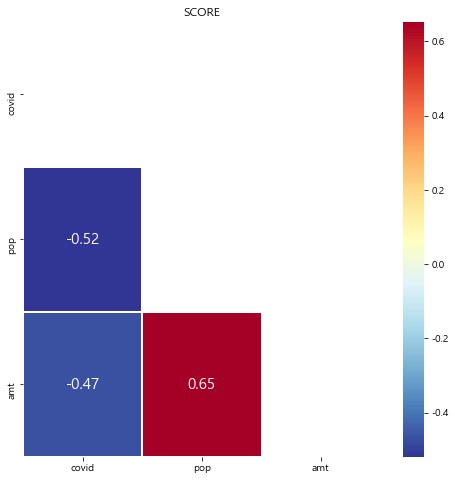

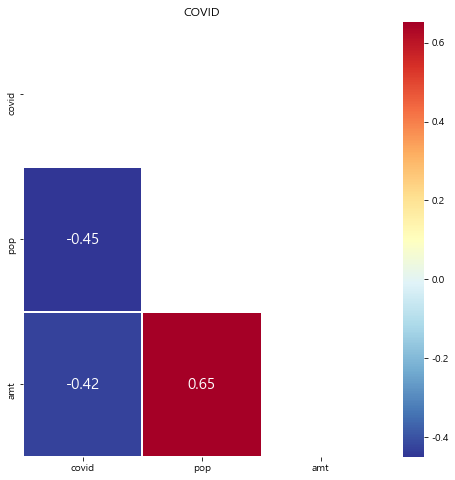

In [52]:
# 전체
corr(event_score['SCORE'], total_sk['Popul'], total_sh['USE_AMT'], 'SCORE')
corr(event_score['확진자수'], total_sk['Popul'], total_sh['USE_AMT'], 'COVID')

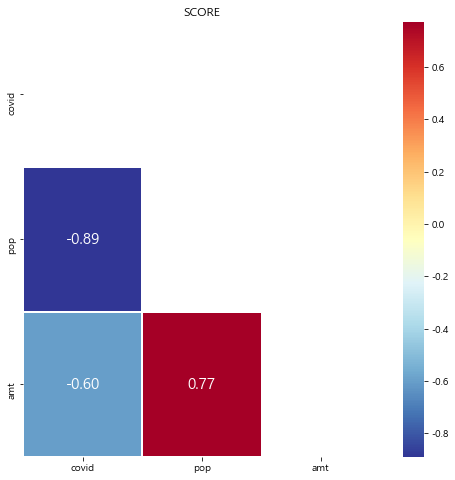

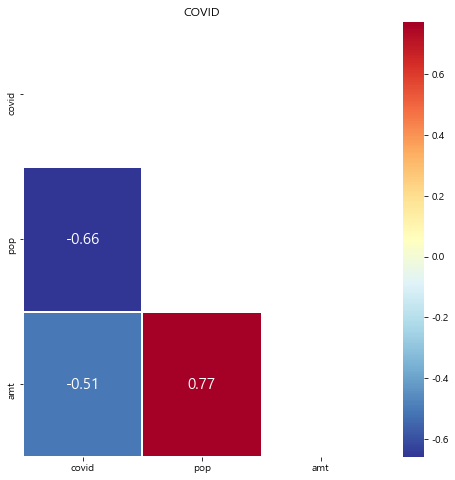

In [53]:
# 월요일
corr(event_score_mon['SCORE'], total_sk_mon['Popul'], total_sh_mon['USE_AMT'], 'SCORE')
corr(event_score_mon['확진자수'], total_sk_mon['Popul'], total_sh_mon['USE_AMT'], 'COVID')

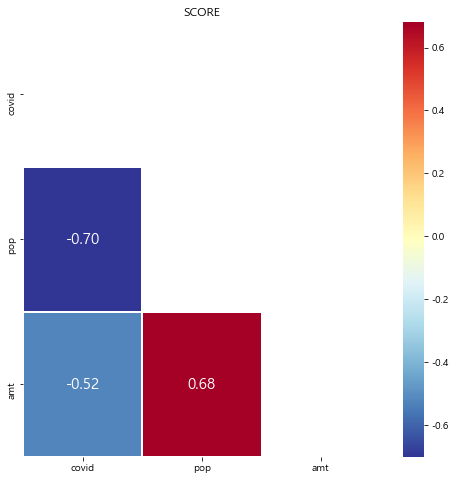

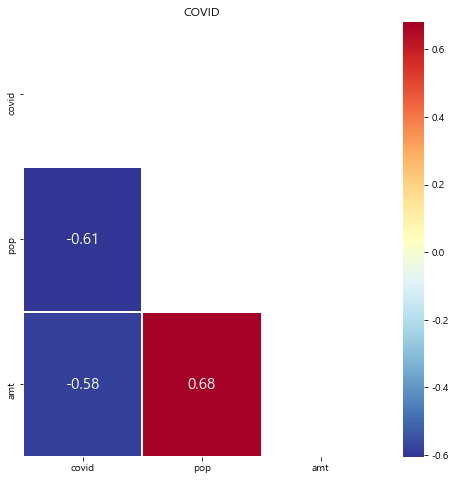

In [24]:
# 화요일
corr(event_score_tue['SCORE'], total_sk_tue['Popul'], total_sh_tue['USE_AMT'], 'SCORE')
corr(event_score_tue['확진자수'], total_sk_tue['Popul'], total_sh_tue['USE_AMT'], 'COVID')

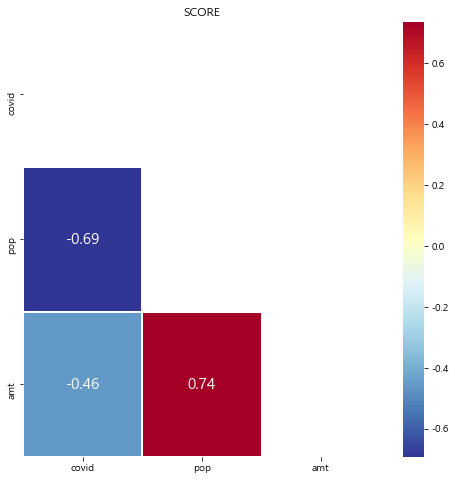

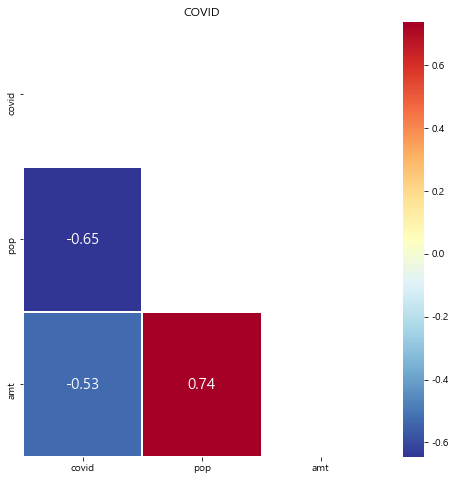

In [25]:
# 수요일
corr(event_score_wed['SCORE'], total_sk_wed['Popul'], total_sh_wed['USE_AMT'], 'SCORE')
corr(event_score_wed['확진자수'], total_sk_wed['Popul'], total_sh_wed['USE_AMT'], 'COVID')

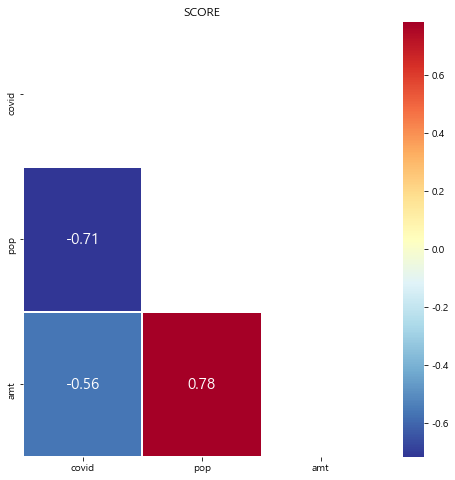

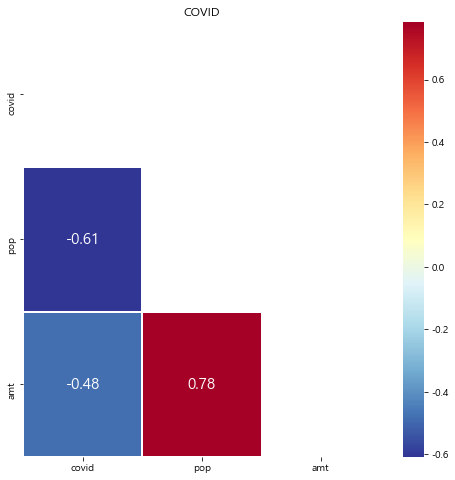

In [26]:
# 목요일
corr(event_score_thu['SCORE'], total_sk_thu['Popul'], total_sh_thu['USE_AMT'], 'SCORE')
corr(event_score_thu['확진자수'], total_sk_thu['Popul'], total_sh_thu['USE_AMT'], 'COVID')

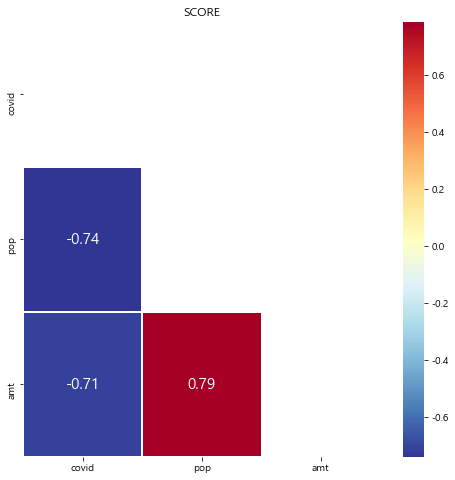

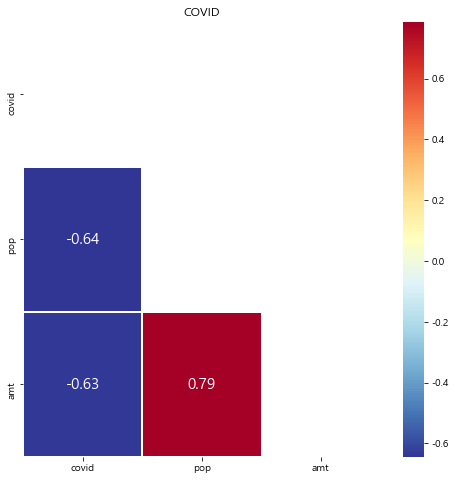

In [43]:
# 금요일
corr(event_score_fri['SCORE'], total_sk_fri['Popul'], total_sh_fri['USE_AMT'], 'SCORE')
corr(event_score_fri['확진자수'], total_sk_fri['Popul'], total_sh_fri['USE_AMT'], 'COVID')

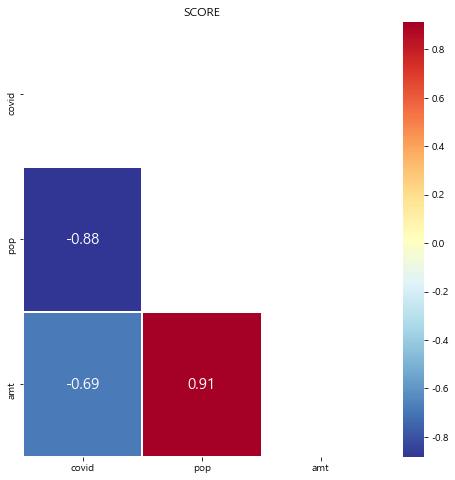

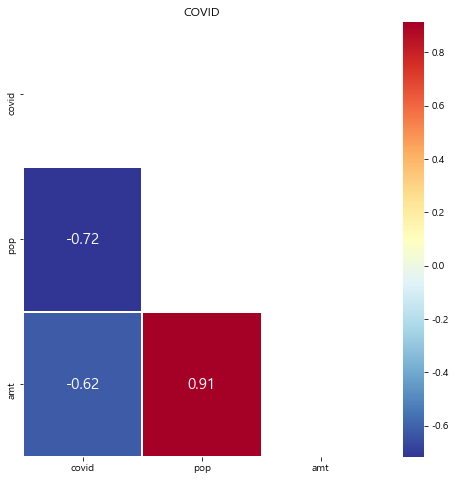

In [54]:
# 토요일
corr(event_score_sat['SCORE'], total_sk_sat['Popul'], total_sh_sat['USE_AMT'], 'SCORE')
corr(event_score_sat['확진자수'], total_sk_sat['Popul'], total_sh_sat['USE_AMT'], 'COVID')

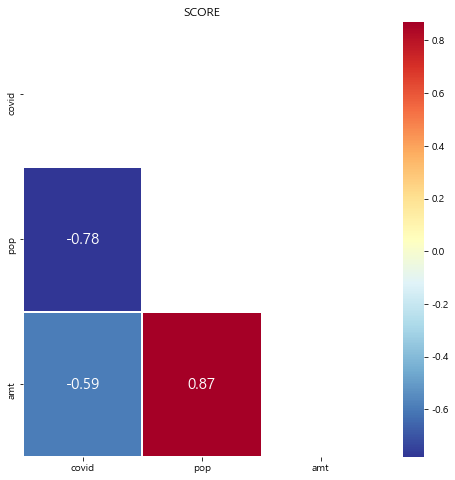

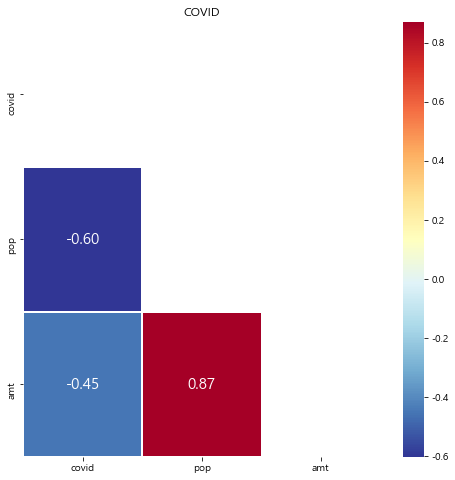

In [61]:
# 일요일
corr(event_score_sun['SCORE'], total_sk_sun['Popul'], total_sh_sun['USE_AMT'], 'SCORE')
corr(event_score_sun['확진자수'], total_sk_sun['Popul'], total_sh_sun['USE_AMT'], 'COVID')

In [58]:
def scatter(df1, df2, x_col, y_col):
    plt.figure(figsize=(20,20))
    df1['DATE'] = df1['DATE'].astype(str)
    df2['DATE'] = df2['DATE'].astype(str)
    
    sns.scatterplot(x=x_col, 
                    y=y_col, 
                    s=100, # marker size
                    data = pd.merge(df1, df2, on='DATE'))

    plt.show()

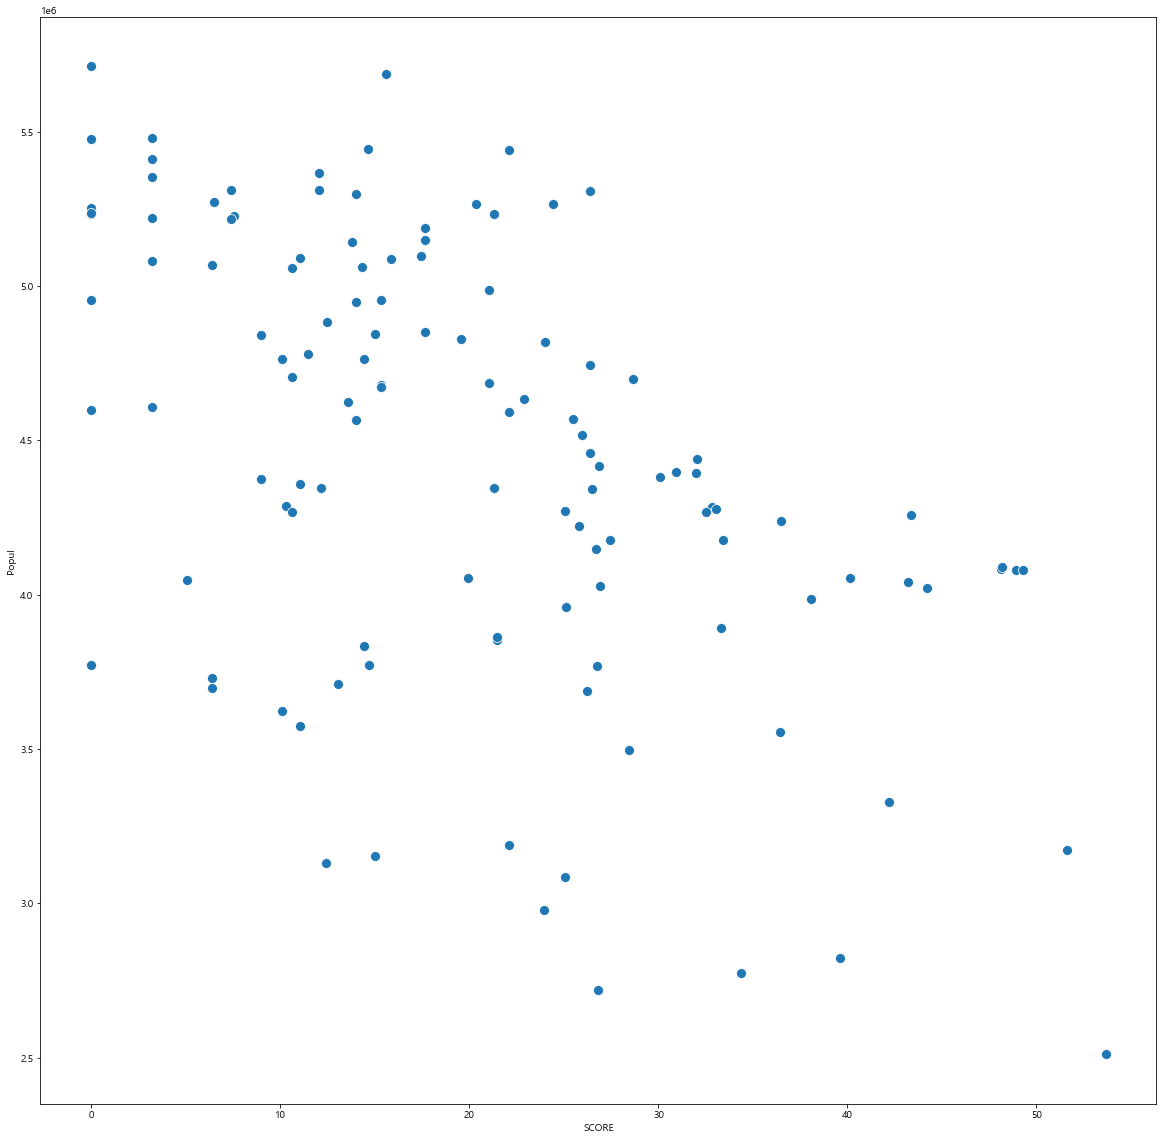

In [57]:
# Event score와 Population scatterplot
scatter(event_score, total_sk, 'SCORE', 'Popul')

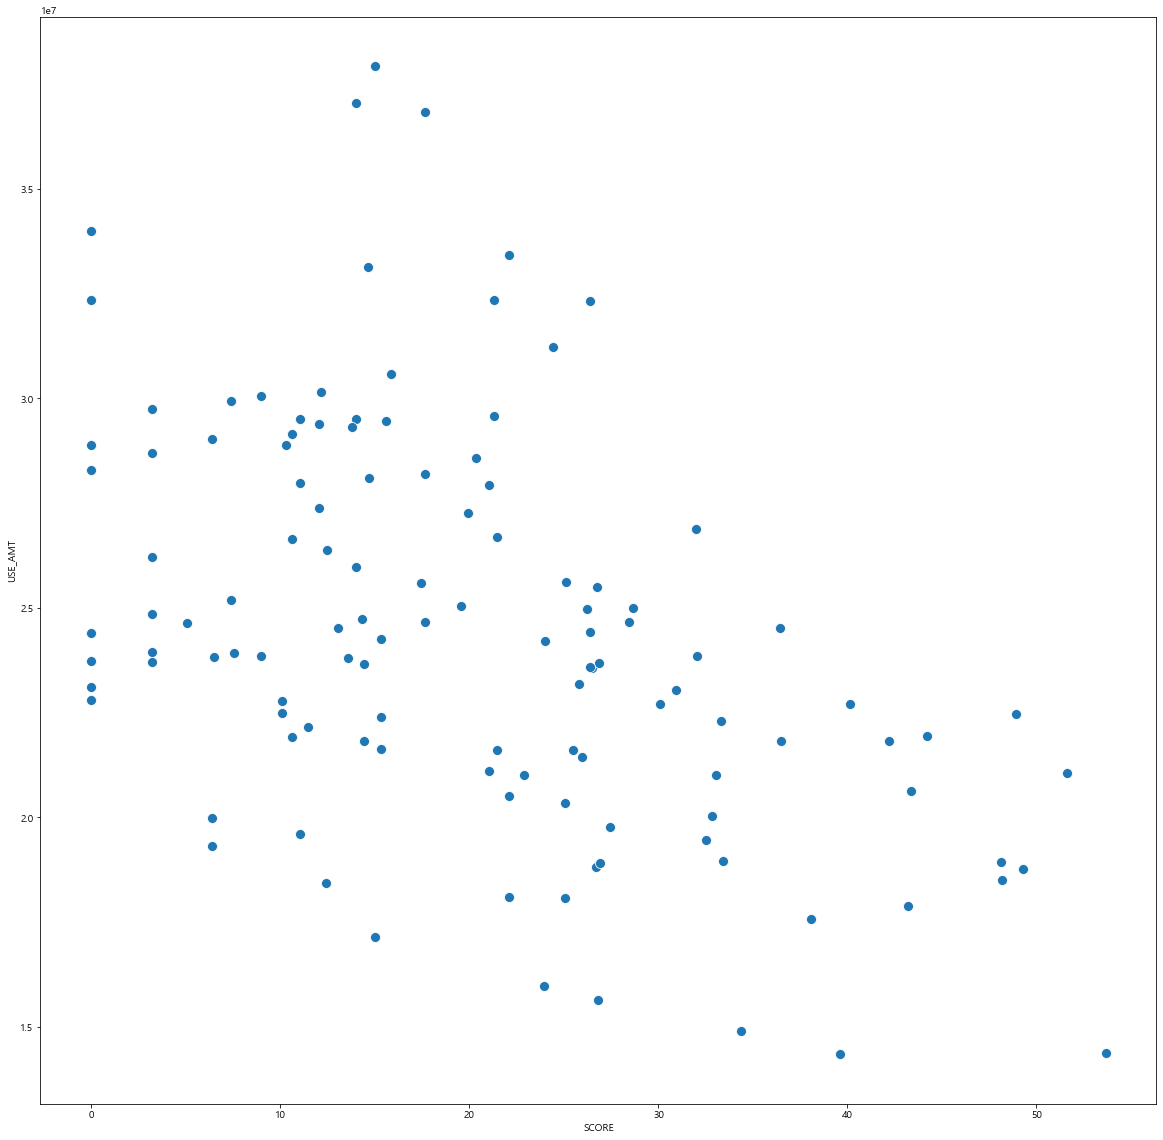

In [59]:
# Event score와 USE_AMT scatterplot
scatter(event_score, total_sh, 'SCORE', 'USE_AMT')

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


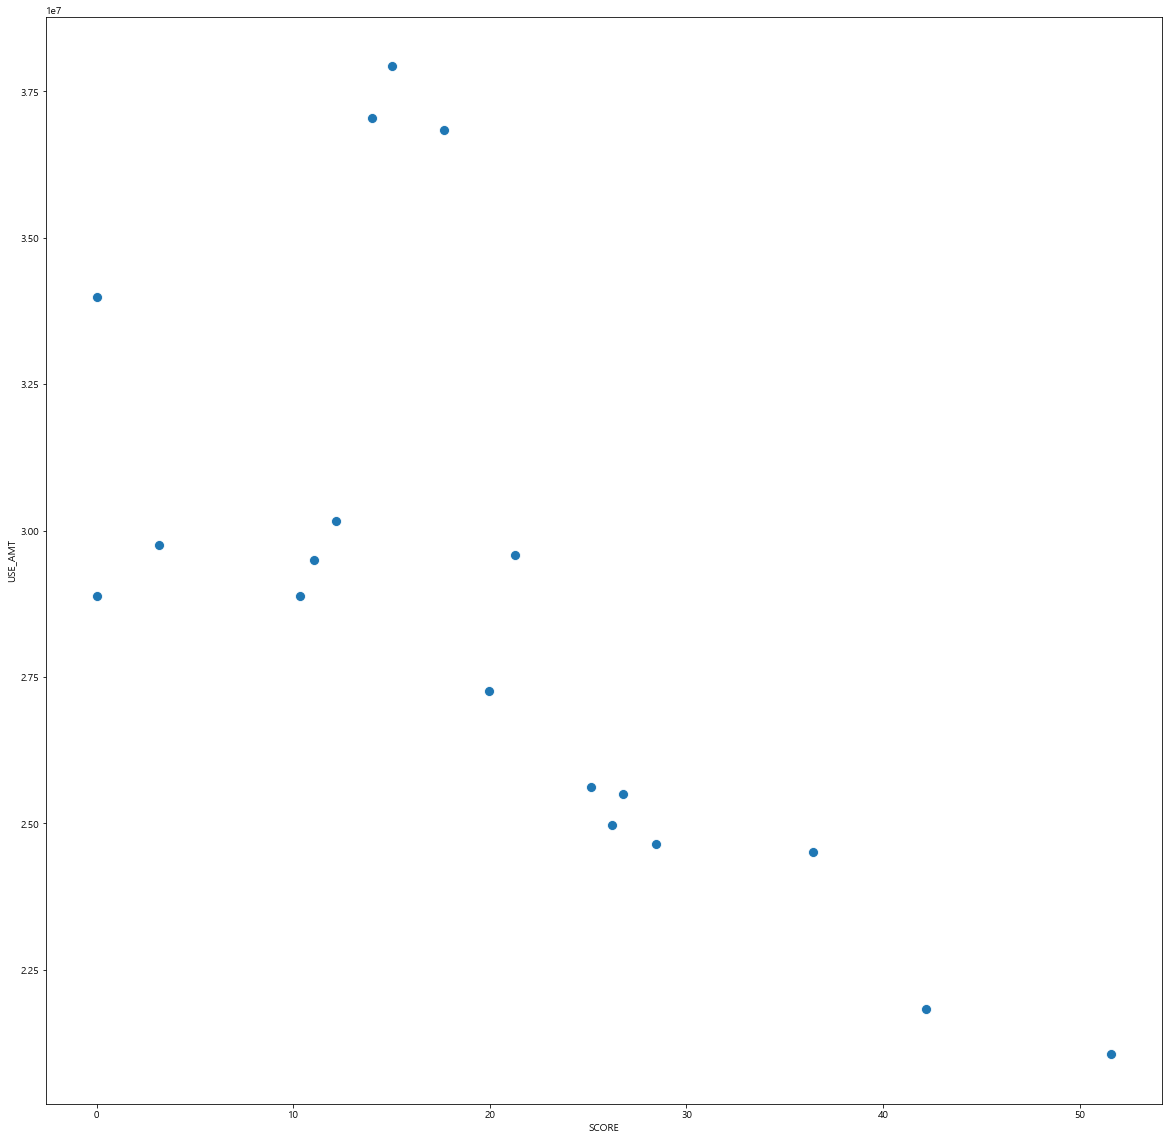

In [60]:
scatter(event_score_sat, total_sh_sat,'SCORE','USE_AMT')